In [1]:
# bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

import math

from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from scipy.interpolate import interp1d
from numpy import median

from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor  
from sklearn.metrics import r2_score

In [2]:
# url para os dados brutos, deixados em um arquivo local e no MS Teams da sprint
url_linhagens = '/home/rafael/Documentos/POS HUB/Agrisolus/agrisolus_ml_horas/agrisolus_ml/linhagens.csv'
url_lotes = '/home/rafael/Documentos/POS HUB/Agrisolus/agrisolus_ml_horas/agrisolus_ml/lotes.csv'
url_pesos = '/home/rafael/Documentos/POS HUB/Agrisolus/agrisolus_ml_horas/agrisolus_ml/pesos.csv'
url_agrisolus = '/home/rafael/Documentos/POS HUB/Agrisolus/agrisolus_ml_horas/agrisolus_ml/agrisolus.csv'

In [3]:
# carregando os dados das linhagens, pesos esperados em funcao da idade
df_linhagens = pd.read_csv(url_linhagens, sep=';')
df_lotes = pd.read_csv(url_lotes, sep=';')
dfagrisolus = pd.read_csv(url_agrisolus, sep=';')

print("dfagrisolus")
print(dfagrisolus.head())
print("df_linhagens")
print(df_linhagens.head())
print("df_lotes")
print(df_lotes.head())

dfagrisolus
   Unnamed: 0                 Data     Peso  Umidade  Temperatura  idLote  \
0           0  2019-04-06 07:10:35  20.5748      0.0          0.0       2   
1           1  2019-04-06 07:10:43  42.5538     68.2         32.1       2   
2           2  2019-04-06 07:10:58  33.6798     67.9         32.1       2   
3           3  2019-04-06 07:12:12  25.7238     68.6         32.1       2   
4           4  2019-04-06 07:13:19  39.4938     68.8         32.0       2   

   idLinhagem  idBalanca       DataAlojamento                     Sexo  \
0          15    2843900  2019-04-06 06:30:00  Fêmeas Cobb MV GT Foods   
1          15    2861839  2019-04-06 06:30:00  Fêmeas Cobb MV GT Foods   
2          15    2861839  2019-04-06 06:30:00  Fêmeas Cobb MV GT Foods   
3          15    2861839  2019-04-06 06:30:00  Fêmeas Cobb MV GT Foods   
4          15    2861839  2019-04-06 06:30:00  Fêmeas Cobb MV GT Foods   

   PesoChegada            DataAbate  Idade  PesoEsperado  DiffPeso  
0         3

In [4]:
# carregando os dados dos sensores especialmente a data e o peso

df_pesos = pd.read_csv(url_pesos, sep=';')
df_pesos.drop('Unnamed: 0', axis=1, inplace=True)
df_pesos.head()

,Data,Peso,Umidade,Temperatura,idLote,idLinhagem,idBalanca
0,2019-04-06 07:10:35,20.5748,0.0,0.0,2,15,2843900
1,2019-04-06 07:10:43,42.5538,68.2,32.1,2,15,2861839
2,2019-04-06 07:10:58,33.6798,67.9,32.1,2,15,2861839
3,2019-04-06 07:12:12,25.7238,68.6,32.1,2,15,2861839
4,2019-04-06 07:13:19,39.4938,68.8,32.0,2,15,2861839


In [5]:
# carregando os dados dos lotes especialmente a data de alojamento que == ao inicio da producao 


df_lotes['DataAlojamento'] = df_lotes['DataAlojamento'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df_lotes.rename(columns={"Linhagem": "idLinhagem", "Lote": "idLote"}, inplace=True)
df_lotes

,idLote,DataAlojamento,idLinhagem,Sexo,PesoChegada,DataAbate
0,2,2019-04-06 06:30:00,15,Fêmeas Cobb MV GT Foods,38.0,2019-05-25 09:30:00
1,1,2019-04-06 06:30:00,16,Mistos Cobb MV GT Foods,38.0,2019-05-20 02:00:00
2,3,2019-06-11 06:30:00,15,Fêmeas Cobb MV GT Foods,46.0,2019-07-30 12:00:00
3,4,2019-06-11 06:30:00,15,Fêmeas Cobb MV GT Foods,46.0,2019-07-29 09:30:00
4,5,2019-08-18 04:50:00,15,Fêmeas Cobb MV GT Foods,44.0,2019-10-02 07:50:00
5,6,2019-08-18 06:40:00,15,Fêmeas Cobb MV GT Foods,40.0,2019-10-02 09:40:00
6,7,2019-10-24 11:30:00,15,Fêmeas Cobb MV GT Foods,47.0,2019-12-08 14:30:00
7,8,2019-10-24 13:00:00,15,Fêmeas Cobb MV GT Foods,50.0,2019-12-08 16:00:00


In [6]:
df_agrisolus = pd.merge(df_pesos, df_lotes, how='left') # juntar info do lote como DataAlojamento e DataAbate

data = df_agrisolus['Data'].values.astype('datetime64[D]')
data_alojamento = df_agrisolus['DataAlojamento'].values.astype('datetime64[D]')
df_agrisolus['idade']=data-data_alojamento

#df_agrisolus.drop('Data', axis=1, inplace=True)
df_agrisolus.drop('DataAlojamento', axis=1, inplace=True)
df_agrisolus.drop('Sexo', axis=1, inplace=True)

df_agrisolus['idade'] = df_agrisolus['idade'].dt.days.astype('int16')

print(df_agrisolus['idade'].describe())

print(df_agrisolus.head())

print("lotes")
print(df_agrisolus['idLote'].unique())
print("Linhagens")
print(df_agrisolus['idLinhagem'].unique())
print("Balanças")
print(df_agrisolus['idBalanca'].unique())


count    2.075588e+06
mean     2.296475e+01
std      1.300428e+01
min      0.000000e+00
25%      1.200000e+01
50%      2.300000e+01
75%      3.400000e+01
max      4.700000e+01
Name: idade, dtype: float64
                  Data     Peso  Umidade  Temperatura  idLote  idLinhagem  \
0  2019-04-06 07:10:35  20.5748      0.0          0.0       2          15   
1  2019-04-06 07:10:43  42.5538     68.2         32.1       2          15   
2  2019-04-06 07:10:58  33.6798     67.9         32.1       2          15   
3  2019-04-06 07:12:12  25.7238     68.6         32.1       2          15   
4  2019-04-06 07:13:19  39.4938     68.8         32.0       2          15   

   idBalanca  PesoChegada            DataAbate  idade  
0    2843900         38.0  2019-05-25 09:30:00      0  
1    2861839         38.0  2019-05-25 09:30:00      0  
2    2861839         38.0  2019-05-25 09:30:00      0  
3    2861839         38.0  2019-05-25 09:30:00      0  
4    2861839         38.0  2019-05-25 09:30:00      0

In [65]:
#filtrando por lote

df_agri = df_agrisolus.loc[df_agrisolus['idLote']==1]
df_agri = df_agri.loc[df_agri['idLinhagem']==16]
df_agri = df_agri.loc[df_agri['idBalanca']==2848352]
df_agri = df_agri.loc[df_agri['idade']>=15]


print(df_agri.shape)
print(df_agrisolus.shape)


#df_agri = df_agri.sample(1000)
X = df_agri[['Umidade','Temperatura','idade']] 

#X = df_agri[['Umidade','Temperatura','idLinhagem','PesoChegada','idade']] 
#X = df_agri[['idade']] 
y = df_agri[['Peso']] 
print(df_agri.head())

(345380, 10)
(2075588, 10)
                       Data       Peso  Umidade  Temperatura  idLote  \
655961  2019-04-21 00:00:02  2134.0283     66.3         27.8       1   
655964  2019-04-21 00:00:06  1972.8949     66.2         27.8       1   
655965  2019-04-21 00:00:10  1913.8025     66.2         27.8       1   
655966  2019-04-21 00:00:13  2226.9313     66.2         27.8       1   
655969  2019-04-21 00:00:17  1389.5859     66.2         27.8       1   

        idLinhagem  idBalanca  PesoChegada            DataAbate  idade  
655961          16    2848352         38.0  2019-05-20 02:00:00     15  
655964          16    2848352         38.0  2019-05-20 02:00:00     15  
655965          16    2848352         38.0  2019-05-20 02:00:00     15  
655966          16    2848352         38.0  2019-05-20 02:00:00     15  
655969          16    2848352         38.0  2019-05-20 02:00:00     15  


In [66]:
df_aux=df_agri[(df_agri['Data'] > '2019-04-20') & (df_agri['Data'] < '2019-04-22')]
print(df_aux['Data'].unique())
df_aux['Peso'].describe()

['2019-04-21 00:00:02' '2019-04-21 00:00:06' '2019-04-21 00:00:10' ...
 '2019-04-21 21:11:13' '2019-04-21 21:11:14' '2019-04-21 21:20:21']


count    13871.000000
mean      1481.379946
std        542.307004
min         20.713500
25%       1091.382500
50%       1509.598300
75%       1859.126800
max       4916.549300
Name: Peso, dtype: float64

In [67]:
len(X)

345380

In [19]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.scatter(X["Umidade"],y,color='g')
plt.xlabel("Umidade")

plt.subplot(222)
plt.scatter(X["Temperatura"],y,color='g')
plt.xlabel("Temperatura")

plt.subplot(223)
plt.scatter(X["idLinhagem"],y,color='g')
plt.xlabel("idLinhagem")

plt.subplot(224)
plt.scatter(X["PesoChegada"],y,color='g')
plt.xlabel("PesoChega")

Text(0.5, 0, 'PesoChega')

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [69]:
from sklearn.neighbors import KNeighborsRegressor

In [70]:
knn = KNeighborsRegressor(n_neighbors=100)

In [71]:
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                    weights='uniform')

In [72]:
pred = knn.predict(X_test)

In [73]:
from sklearn.metrics import classification_report, confusion_matrix

In [74]:
from sklearn.metrics import r2_score
def calc_rss(y,predicted):
    return float(((predicted - y) ** 2).sum())
    
def calc_r2(y,predicted):
    return r2_score(y, predicted)

In [75]:
rss = calc_rss(pred,y_test)
r2 = calc_r2(pred,y_test)
print(rss)
print(r2)

73068234710.05263
-0.9638246762293399


In [76]:
error_rate = []
rss_error = []

for i in range(10,400,10):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(calc_r2(pred_i,y_test))
    rss_error.append(calc_rss(pred_i,y_test))

Text(0, 0.5, 'RSS')

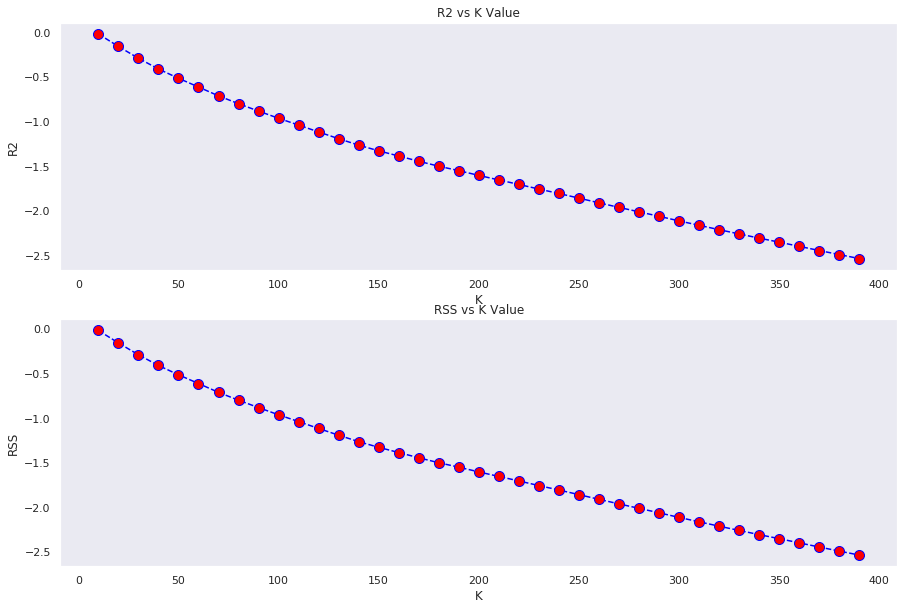

In [78]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(range(10,400,10), error_rate, color="blue", linestyle="dashed", marker="o", markerfacecolor="red", markersize=10)
plt.title("R2 vs K Value")
plt.grid()
plt.xlabel("K")
plt.ylabel("R2")

plt.subplot(2,1,2)
plt.plot(range(10,400,10), error_rate, color="blue", linestyle="dashed", marker="o", markerfacecolor="red", markersize=10)
plt.title("RSS vs K Value")
plt.grid()
plt.xlabel("K")
plt.ylabel("RSS")